In [1]:
import sys,re, os, glob, json, string, pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from snowballstemmer import TurkishStemmer 
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from difflib import SequenceMatcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

## Global Variables

In [2]:
word_size_threshold = 100
similarity_ratio = 0.90
#path = "datasets/*.json"
path = "C://Users/onkol/Desktop/2021-01-20220322T055600Z-001/2021-01/*.json" 
create_data_json = True
enable_preprocessing = True

## Read Datasets

In [3]:
files = glob.glob(path)

json_arr = []
for file in files:
    f = open(file, "r", encoding='utf-8')
    jsonData = json.loads(f.read())
    json_arr.append(jsonData)


## Create labels from dataset

In [4]:
if(not create_data_json):
    raise Exception("NOT ERROR - SKIPPINIG")

def has_key(dict, key): 
    if key in dict.keys(): 
        return 1 
    return 0

labels = {} 

def cosine_sim(vec1, vec2):
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    return  cosine_similarity(vec1,vec2)[0][0]

def similarity(a, b):
    words_in_a = a.replace(',', ' ').split()
    words_in_b = b.replace(',', ' ').split()
    if(len(words_in_a) ==  1 and words_in_a[0] in words_in_b):
        return 1
    if(len(words_in_b) ==  1 and words_in_b[0] in words_in_a):
        return -1
    
    total_ratio = 0
    for word_a in words_in_a:
        a_ratio = 0
        for word_b in words_in_b:
            b_ratio = SequenceMatcher(None, a, b).ratio()
            if(b_ratio > a_ratio):
                a_ratio = b_ratio
        total_ratio += a_ratio
    
    return total_ratio / len(words_in_a)

def readLabels(jsonData): 
    key = jsonData["Suç"].strip().lower() if jsonData["Suç"] != '' else "undefined"
    if (not has_key(labels, key)):
        labels[key] = 1    
    else :
        labels[key] = labels[key] + 1

for file in json_arr: 
    readLabels(file)

items = list(map(lambda x: list(x), labels.items()))
labels_array = sorted(items, key=lambda x: x[1], reverse=True)

vectorize_array = list(map(lambda x: x[0], labels_array))
vectorizer = TfidfVectorizer().fit_transform(vectorize_array)
vectors = vectorizer.toarray()

len_labels_array = len(labels_array)
for i in range(0, len_labels_array):
    
    for j in range(i, len_labels_array):
        if labels_array[i][0] == labels_array[j][0] or labels_array[i][1] <= 1 or labels_array[j][1] <= 1 :
            continue
        
        i_search = re.search('([0-9].*) sayılı', labels_array[i][0])
        j_search = re.search('([0-9].*) sayılı', labels_array[j][0])
        if(j_search != None and i_search != None):
            if(i_search[0] == j_search[0]):
                labels_array[i][1] += labels_array[j][1]
                labels_array[j][1] = 0
                continue
            else:
                continue
        
        cos_similarity = cosine_sim(vectors[i], vectors[j])
        if cos_similarity > similarity_ratio:
            labels_array[i][1] += labels_array[j][1]
            labels_array[j][1] = 0
            continue
        
        similarity_result = similarity(labels_array[i][0], labels_array[j][0])
        if similarity_result == -1:
            labels_array[j][1] += labels_array[i][1]
            labels_array[i][1] = 0
        elif similarity_result > similarity_ratio:
            labels_array[i][1] += labels_array[j][1]
            labels_array[j][1] = 0



array_final = (list(filter(lambda x: x[1] > 1 , labels_array)))

    
array_final = sorted(array_final, key=lambda x: x[1], reverse=True)

    
jsonString = json.dumps(array_final, indent = 4, ensure_ascii=False)
jsonFile = open("data.json", "w", encoding='utf-8')
jsonFile.write(jsonString)
jsonFile.close()


## Read data.json


-------- Labels and their corresponding occurences --------


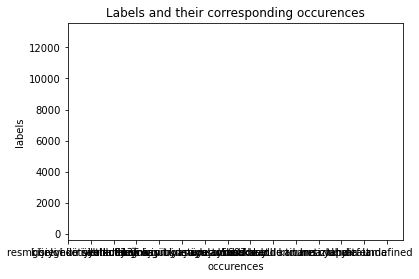

In [5]:
if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")
    
ictihats = []
suc_array = []

def draw_chart(options):
    print("\n--------",options["title"],"--------")
    data = pd.read_csv(options["file"]) 
    words = []
    words = data.head(15)[data.columns[1]]
    freqs = data.head(15)[data.columns[0]]
    colors = ['#bc80bd', '#fb8072', '#80b1d3', '#8dd3c7', '#fdb462',
              '#b3de69', '#bebada', '#F3D1B0', '#fccde5', '#d9d9d9']

    reversed_words = words[::-1]
    reversed_freqs = freqs[::-1]
    # plt.bar(words,freqs)
    # plt.title('-------- ' + options["title"] + ' --------')
    # plt.xticks(rotation=90)
    # plt.xlabel('Collocations')
    # plt.ylabel('Score')
    # plt.show() 

    plt.barh(reversed_words, reversed_freqs, color=colors)
    plt.ylabel("labels")
    plt.xlabel("occurences")
    plt.title(options["title"])
    plt.show()

def similar(a, topTenCrimes):
    for crime in topTenCrimes:
        if SequenceMatcher(None, a, crime).ratio() > similarity_ratio:
            return crime
    return None
                
top_ten_crimes = []
top_ten_results = []
with open("data.json", encoding='utf-8') as jsonFile:
    data = json.load(jsonFile)
    top_ten_crimes = list(map(lambda x: x[0], data[:15]))
    top_ten_results = list(map(lambda x: x[1], data[:15]))

df_chart = pd.DataFrame(columns= {'crimes', 'results'})
df_chart['crimes'] = top_ten_crimes
df_chart['results'] = top_ten_results
df_chart.to_csv('chart.csv', encoding='utf-8', index = False)

   
for jsonData in json_arr:
    key = jsonData["Suç"] if jsonData["Suç"] != '' else "undefined"
    similar_suc = similar(key, top_ten_crimes)
    
    key = similar_suc if similar_suc is not None else key
    suc = key if key in top_ten_crimes or key == 'undefined' else "other"

    new_ictihat = jsonData['ictihat'].strip()
    ictihats.append(new_ictihat)
    new_ictihat_ctr = new_ictihat.split()
    num_of_words = len(new_ictihat_ctr)
    suc_array.append(suc.strip())

draw_chart({"file": 'chart.csv', "title": "Labels and their corresponding occurences"})

## Preprocessing

In [6]:
if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")

ictihats_lower = []
for i in ictihats:
    i = i.lower()
    ictihats_lower.append(i)
    

ictihats_punctuation = []

file = open("stopwords.txt", "r", newline='', encoding='utf-8')
result = file.read()
stopwords = word_tokenize(result)

for ictihat in ictihats_lower:
    ictihat = ictihat.translate(str.maketrans("", "", string.punctuation))
    #print(ictihat)
    tokenized_words = ([word for word in ictihat.split() if word not in stopwords and len(word) > 1 and re.match("^[A-Z0-9a-zğüşöçİĞÜŞÖÇ]*$", word)])
    #print(tokenized_words)
    ictihats_punctuation.append(' '.join(tokenized_words[:word_size_threshold]))
    



# print(ictihats_punctuation[:10])   
# preprocessed_ictihats = []
# for i in ictihats_punctuation:
#     preprocessed_ictihats.append(list(filter(lambda x: x != "",i.split(" "))))

# print(preprocessed_ictihats)
turkStem = TurkishStemmer()
for index, ictihat in enumerate(ictihats_punctuation,start=0):
    #print([turkStem.stemWord(word) for word in ictihat])
    ictihats_punctuation[index] = ' '.join([turkStem.stemWord(word) for word in ictihat.split()])
    
#print(ictihats_punctuation)

## write data into csv file

In [7]:
if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")

df = pd.DataFrame(columns = ['ictihats', 'sucs'])
df['ictihats'] = ictihats_punctuation
df['sucs'] = suc_array
csv_file_name = 'train_set_' + str(word_size_threshold) + '.csv'

df.to_csv(csv_file_name, encoding='utf-8', index=False)


## Read train set from CSV

In [8]:
csv_file_name = 'train_set_' + str(word_size_threshold) + '.csv'
my_csv = pd.read_csv(csv_file_name, dtype=str, na_filter=False)

ictihats_punctuation = my_csv['ictihats'].tolist()
suc_array = my_csv['sucs'].tolist()

for item in ictihats_punctuation:
    if(type(item).__name__ != "str"):
        print(item)



## Split Dataset

In [9]:
x_train, x_test, y_train, y_test = train_test_split(ictihats_punctuation, 
                                                    suc_array, 
                                                    test_size=0.20,random_state=36)

## Vectorize

In [10]:
tfidfvectorizer = TfidfVectorizer(analyzer='word')
training_data = tfidfvectorizer.fit_transform(x_train)
testing_data = tfidfvectorizer.transform(x_test)


## Support Vector Machines (specifically linear SVM)

In [11]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(training_data, y_train)
y_pred = svclassifier.predict(testing_data)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  50    0    0    0    0   39    0    0    0    0]
 [   0    8    0    0    0   31    0    0    0    0]
 [   0    0    1    0    0   20    0    0    0    0]
 [   0    0    0    2    0   47    0    0    0    0]
 [   0    0    0    0   60    3    0    0    0    4]
 [  23    5    0    0    1 2412    2    5    6   19]
 [   0    0    0    0    0   20   11    0    0    0]
 [   0    0    0    0    0    2    0   56    0    0]
 [   0    1    1    0    1   31    0    0 2577    3]
 [   0    0    0    0    2    1    0    0    0  127]]
                                            precision    recall  f1-score   support

              5607 sayılı kanuna muhalefet       0.68      0.56      0.62        89
              6136 sayılı yasaya aykırılık       0.57      0.21      0.30        39
                    görevi kötüye kullanma       0.50      0.05      0.09        21
         kişiyi hürriyetinden yoksun kılma       1.00      0.04      0.08        49
kullanmak için uyuşturucu madde bulundurma      

## Multinomial Naive Bayes

In [12]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))


[[   0    0    0    0    0   89    0    0    0    0]
 [   0    0    0    0    0   38    0    0    1    0]
 [   0    0    0    0    0   20    0    0    1    0]
 [   0    0    0    0    0   49    0    0    0    0]
 [   0    0    0    0    0   61    0    0    6    0]
 [   0    0    0    0    0 2443    0    0   30    0]
 [   0    0    0    0    0   29    0    0    2    0]
 [   0    0    0    0    0   58    0    0    0    0]
 [   0    0    0    0    0  340    0    0 2274    0]
 [   0    0    0    0    0  105    0    0   25    0]]
                                            precision    recall  f1-score   support

              5607 sayılı kanuna muhalefet       0.00      0.00      0.00        89
              6136 sayılı yasaya aykırılık       0.00      0.00      0.00        39
                    görevi kötüye kullanma       0.00      0.00      0.00        21
         kişiyi hürriyetinden yoksun kılma       0.00      0.00      0.00        49
kullanmak için uyuşturucu madde bulundurma      

C:\Users\onkol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\onkol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\onkol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [13]:
log_regres_classifier = LogisticRegression(random_state = 36)
log_regres_classifier.fit(training_data, y_train)
y_pred = log_regres_classifier.predict(testing_data)
cm = confusion_matrix(y_test, y_pred)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


C:\Users\onkol\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[  54    0    0    0    0   34    0    0    1    0]
 [   0    8    0    0    0   31    0    0    0    0]
 [   0    0    1    0    0   20    0    0    0    0]
 [   0    0    0    3    0   46    0    0    0    0]
 [   0    0    0    0   54    8    0    0    1    4]
 [  18    6    0    1    1 2412    1    4   13   17]
 [   0    0    0    0    0   24    7    0    0    0]
 [   0    0    0    0    0    3    0   55    0    0]
 [   1    0    0    0    1   53    0    0 2555    4]
 [   0    0    0    0    2    8    0    0    0  120]]
                                            precision    recall  f1-score   support

              5607 sayılı kanuna muhalefet       0.74      0.61      0.67        89
              6136 sayılı yasaya aykırılık       0.57      0.21      0.30        39
                    görevi kötüye kullanma       1.00      0.05      0.09        21
         kişiyi hürriyetinden yoksun kılma       0.75      0.06      0.11        49
kullanmak için uyuşturucu madde bulundurma      

In [14]:
#print(len(suc_array))
#print(ictihats_punctuation)
# index_list = []
# for i in range(0,100):
#     index_list.append(str(i))

# preprocessed_ictihats = []
# for i in ictihats_punctuation:
#        preprocessed_ictihats.append(list(filter(lambda x: x != "",i.split(" "))))

# #print(preprocessed_ictihats)
# turkStem = TurkishStemmer()
# for index, ictihat in enumerate(preprocessed_ictihats,start=0):
#     preprocessed_ictihats[index] = [turkStem.stemWord(word) for word in ictihat]
    
#print(preprocessed_ictihats)

#tfidf_wm_array
#tfidf_wm_array.shape
# frequency_matrix = pd.DataFrame(tfidf_wm_array, columns=tfidfvectorizer.get_feature_names())
# from sklearn.model_selection import train_test_split
# y = np.array([0,1,2,3,4,5,6,7,8,9,10]) 


# naive_bayes = MultinomialNB()
# naive_bayes.fit(training_data, y_train)

# predictions = naive_bayes.predict(testing_data)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
# print('Precision score: ', format(precision_score(y_test, predictions,
#                                            average='macro')))
# print('Recall score: ', format(recall_score(y_test, predictions
#                                            ,average='macro')))
# print('F1 score: ', format(f1_score(y_test, predictions
#                                            ,average='macro')))

# print(confusion_matrix(y_test,predictions))


# from sklearn.svm import SVC
# svclassifier = SVC(kernel='linear')
# svclassifier.fit(training_data, y_train)
# y_pred = svclassifier.predict(testing_data)

# from sklearn.metrics import classification_report, confusion_matrix
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))



# frequency_matrix
# print(tfidfvectorizer.vocabulary_)
# print(tfidf_wm.toarray())
# tfidf_tokens = tfidfvectorizer.get_feature_names()
# df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = index_list,columns = tfidf_tokens)
# print("\nTD-IDF Vectorizer\n")
# print(df_tfidfvect)
# vectorizer.get_feature_names_out()
# ictihat_freq = []


# for i in preprocessed_ictihats:
#     count_freq = Counter(i)
#     ictihat_freq.append(count_freq)
    
# pprint.pprint(ictihat_freq)

